In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
%matplotlib inline

In [2]:
torch.cuda.get_device_name()

'Tesla P100-PCIE-16GB'

In [3]:
dataset = MNIST(root="data/", download=True, transform=ToTensor())

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [5]:
train_dl = DataLoader(train_ds, batch_size=100, shuffle=True, num_workers=4, pin_memory=True)
val_dl_ = DataLoader(val_ds, batch_size=1, num_workers=4, pin_memory=True)

In [6]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(512, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = x.view(-1, 512)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)

        x = self.fc2(x)
        
        return x

    def training_step(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        return loss
        
    def validation_step(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        acc = accuracy(outputs, labels)
        return {"val_loss": loss, "val_acc": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [i["val_loss"] for i in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [i["val_acc"] for i in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch, results):
        print("Epoch: [{}] | val_loss: {:.4f} | val_acc: {:.4f}".format(epoch, results['val_loss'], results['val_acc']))

In [8]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [9]:
device = get_default_device()
device

device(type='cuda')

In [10]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
        
    return data.to(device, non_blocking=True)

In [11]:
for images, labels in train_dl:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([100, 1, 28, 28])
cuda:0


In [12]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for d in self.dl: 
            yield to_device(d, self.device)

    def __len__(self):
        return len(self.dl)

In [13]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl_, device)

In [14]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader):
    history = []
    opt = torch.optim.SGD(model.parameters(), lr)
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            opt.step()
            opt.zero_grad()

        result = evaluate(model, val_loader)
        if epoch % 10 == 0:
            model.epoch_end(epoch, result)
        history.append(result)

    return history

In [15]:
model = Net()

In [16]:
to_device(model, device)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

In [17]:
results = evaluate(model, val_dl)
results

{'val_acc': 0.11640000343322754, 'val_loss': 2.3057594299316406}

In [18]:
history = fit(41, 1e-3, model, train_dl, val_dl)

Epoch: [0] | val_loss: 2.2994 | val_acc: 0.1196
Epoch: [10] | val_loss: 2.0297 | val_acc: 0.3302
Epoch: [20] | val_loss: 1.0266 | val_acc: 0.6580
Epoch: [30] | val_loss: 0.7639 | val_acc: 0.7436
Epoch: [40] | val_loss: 0.6639 | val_acc: 0.7871


In [19]:
def fgsm(image, epsilon, grad_image):
    sign_grad_image = grad_image.sign()
    perturbed_image = image + epsilon*sign_grad_image
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    return perturbed_image

In [27]:
def attack(model, val_dl, epsilon):
    correct = 0
    seen_labels = []
    adv_eg = []

    for image, label in val_dl:
        image.requires_grad = True
        output = model(image)
        _, init_pred = torch.max(output, dim=1)
        if init_pred.item() != label.item():
            continue

        loss = F.cross_entropy(output, label)
        model.zero_grad()
        loss.backward()
        grad_image = image.grad.data

        perturbed_image = fgsm(image, epsilon, grad_image)
        output = model(perturbed_image)

        _, final_pred = torch.max(output, dim=1)
        if final_pred.item() == label.item():
            correct += 1
        else:
            if label not in seen_labels:
                seen_labels.append(label)
                adv_example = perturbed_image.squeeze().detach().cpu().numpy()
                adv_eg.append([init_pred.item(), final_pred.item(), adv_example])

    acc = correct/len(val_dl)
    print(f"Accuracy: {acc * 100}")

    return acc, adv_eg

In [28]:
_, adv_examples = attack(model, val_dl, epsilon=0.1)

Accuracy: 52.059999999999995


In [38]:
len(adv_examples)

10

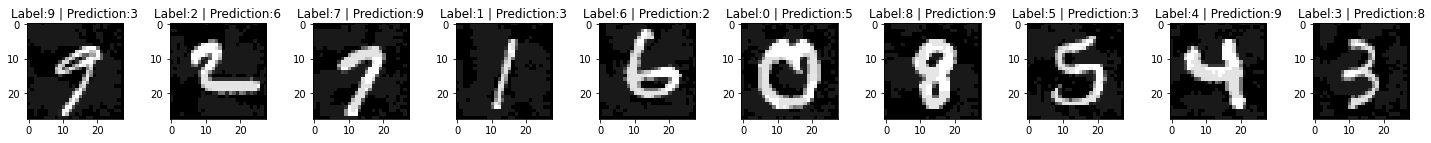

In [54]:
cnt = 0
plt.figure(figsize=(20,20))

for i in range(len(adv_examples)):
    cnt += 1
    plt.subplot(1, 10, cnt)
    example = list(adv_examples[i])
    original, after_attack, eg = example
    plt.title(f"Label:{original} | Prediction:{after_attack}")
    plt.imshow(eg, cmap="gray")
    
plt.tight_layout()
plt.show()